In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
import pandas as pd

In [2]:
%load_ext autoreload
%aimport contrastive_data

In [3]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *
from glob import glob

# Data and model

In [4]:
GENE = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{GENE}/'


In [5]:
group_wt_like = False
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=group_wt_like)

	Reading files...
		Reading matrix
		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [6]:
variant_data = pd.read_csv(paths[4], index_col=0)
variant_data.loc['control'] = pd.Series({'Control status':'synonymous','Variant functional class':'WT-like'})

In [7]:
with gzip.open(paths[3]) as file: # read cell tags
    v2c = pd.read_csv(file, sep='\t', usecols=['cell','variant'], index_col=1).squeeze()
v2c = v2c[counts.index]
v2c.shape

(87262,)

## Run from here to re-split without reloading all data

(will be necessary if wtlike is changed however)

In [8]:
#CELL TO CHANGE
run_name = 'cls_kras_mil_142'
run_dir = 'cls_kras_mil/cls_kras_mil_142'
BAG_SIZE = 34
dir_name = join('models',run_dir)
dataset_class = ClassifierBagDatasetWithIDs
! cat models/{run_dir}/config.ini

dest-name = cls_kras_mil
verbose = 1
loss = standard
margin = 0.8832454936577412
dropout = 0.004437153049590033
weight-decay = 0.034898361539582
batch-size = 512
positive-fraction = 0.4544352077523933
shape = [481, 481, 481]
embed-dim = 20
lr = 0.051257027374908136
scheduler = plateau
patience = 30
cosine-t = 512
task = classifier
bag-size = 34
mil-mode = attention
alpha = 0
n-epochs = 600
knn = 5
n-workers = 0


In [9]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

48550, 16184, 22528 exemples in data
73 variants in train
24 variants in unseen


In [10]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=dataset_class,n_workers=1,pos_frac=0.5, 
    dataset_kwargs={'bag_size':BAG_SIZE})
dl_dict = {
    'train':dl_train,
    'seen':dl_seen,
    'unseen':dl_unseen,
}

In [11]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Classifier(
  (network): AttentionMIL(
    (model): MLP(
      (layers): Sequential(
        (0): Linear(in_features=1145, out_features=481, bias=True)
        (1): ELU(alpha=1.0)
        (2): Dropout(p=0.004437153049590033, inplace=False)
        (3): Linear(in_features=481, out_features=481, bias=True)
        (4): ELU(alpha=1.0)
        (5): Dropout(p=0.004437153049590033, inplace=False)
        (6): Linear(in_features=481, out_features=481, bias=True)
        (7): ELU(alpha=1.0)
        (8): Dropout(p=0.004437153049590033, inplace=False)
        (9): Linear(in_features=481, out_features=20, bias=True)
      )
    )
    (att1): Linear(in_features=20, out_features=64, bias=True)
    (att2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=73, bias=True)
)

## Compute embeddings

In [12]:
df_dict['train'].shape

(48550, 1148)

In [13]:
emb_dict = {}
x_dict = {}
y_dict = {}
id_dict = {}
for k, dl in dl_dict.items():
    X = []
    Y = []
    embs = []
    ids = []
    for x,y in dl:
        X.append(x[0])
        Y.append(y[0])
        ids.append(y[1])
        with torch.no_grad():
            embs.append(model.network.embed(x[0]))
    Y = pd.Series(dl.dataset.cats[torch.cat(Y)], name='variant')
    X = torch.cat(X)
    ids = torch.cat(ids)
    embs = torch.cat(embs)

    emb_dict[k] = embs
    x_dict[k] = X
    y_dict[k] = Y
    id_dict[k] = ids
 

(1396, 34)
(438, 34)
(651, 34)


In [14]:
id_dict['train'].shape

torch.Size([1396, 34])

In [15]:
y_dict['train']

0         A59E
1         G60S
2         L79I
3         D30D
4       AG11TD
         ...  
1391      T20M
1392      G12A
1393      P34L
1394      G12V
1395      G12F
Name: variant, Length: 1396, dtype: object

# Embed PCA

In [16]:
pca = PCA(2).fit(emb_dict['seen'])

In [17]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')

Explained variance : 79.2 %


# Embedding distribution

In [18]:
make_dir_if_needed(f'plots/embeds/{run_name}_mil')
make_dir_if_needed(f'plots/attn/{run_name}/')
hue_order = ['WT-like', 'Impactful I', 'Impactful II', 'Impactful III', 'Impactful IV']
hue_order_cycle = ['M.G1','G1.S','S','G2.M','M','Uncycling'] 
if GENE == 'TP53':
    hue_order =  ['WT-like', 'Impactful I', 'Impactful II',] 

In [19]:
subset = 'seen'
y = y_dict[subset]
embeds = emb_dict[subset]
vfc = variant_data.loc[y]['Variant functional class']
emb_red = pca.transform(embeds)

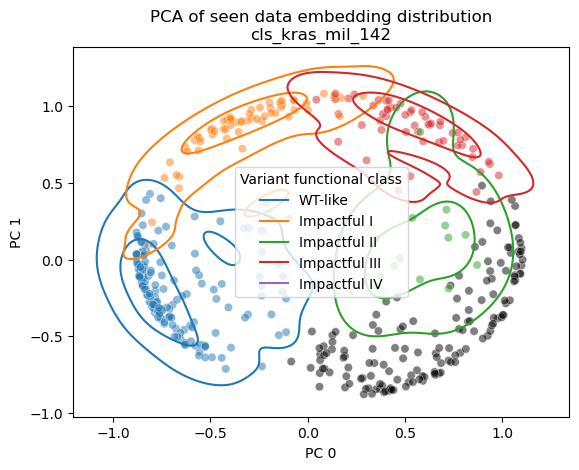

In [20]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = vfc, 
                hue_order=hue_order, alpha=0.1 if subset=='train' else 0.5, legend=False)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = vfc, 
            hue_order=hue_order, levels=3, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}_mil/{subset}_embed_pca_kde.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


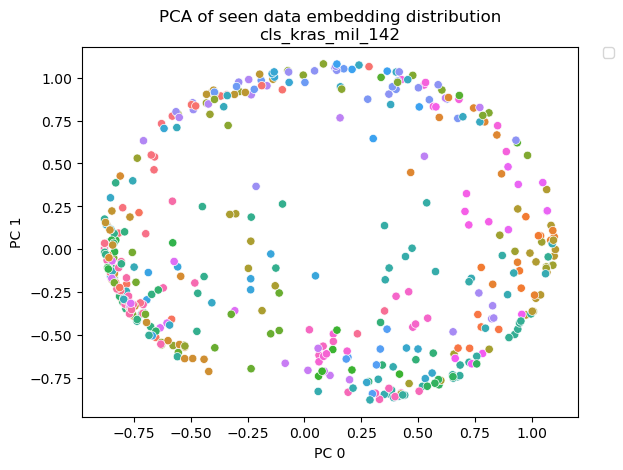

In [21]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = y, 
              alpha=1, legend=False)
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = vfc, 
#             hue_order=hue_order, levels=3, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig(f'plots/embeds/{run_name}_mil/{subset}_embed_pca_kde.pdf')

Text(0.5, 1.0, 'PCA of R273C  embedding distribution\ncls_kras_mil_142, seen')

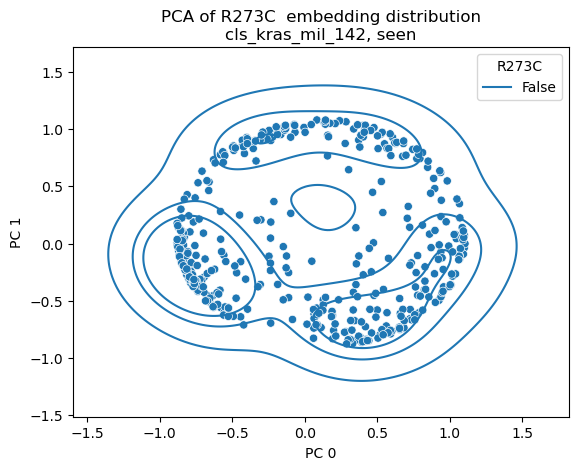

In [22]:
variant = 'R273C'
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =y==variant,  alpha=0.5 if subset == 'train' else 1, legend=False)
f = y== variant

sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue =(y==variant).rename(variant), legend=True, common_norm=False, levels = 4)

plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {variant}  embedding distribution\n{run_name}, {subset}' )

# Model scoring

See results.ipynb

# Attention extraction

NB : we're extracting attention logits, not softmaxed, to remove bag effect

In particular, this means that comparison between variants should be to a constant, as bags only contain cells from one variant and softmax is invariant to addition of a constant 

This also mean that we're iterating over cells, not bags

In [23]:
import torch.nn.functional as f
# should be in the model itself, but in the meantime we can add it here
def att_weights(self, x:Tensor) -> Tensor: 
    '''
    Return attention weights for visualization
    Shape : (batch_size, n_instances, input_shape)'''
    x = self.model.embed(x)
    a = f.tanh(self.att1(x))
    a = self.att2(a)
    return a



In [24]:
emb_dict = {}
attn_dict = {}

for k, df in df_dict.items():
    X = torch.tensor(df.drop(columns=['variant','Variant functional class','cycle' ]).to_numpy(), dtype=torch.float32)[:, None, None, :] #(B, 1, 1, d)

    with torch.no_grad():
        embeds=(model.network.embed(X[:,None,:]).squeeze())
        attn=(att_weights(model.network, X).squeeze())
    attn_dict[k] = pd.Series(attn, name='attn', index = df.index)
    # emb_dict[k] = embeds
    emb_dict[k] = (embeds - embeds.mean(0))/embeds.std(0)    

In [25]:
avg_attn = attn_dict['train'].groupby(df_train.variant).mean()
avg_attn

variant
V8V      -0.234946
A59T      0.209133
AG59GV    0.211944
N26Y      0.205554
Q61P      0.114499
            ...   
G13V           NaN
T50P           NaN
T20T           NaN
K178K          NaN
I163S          NaN
Name: attn, Length: 97, dtype: float32

In [26]:
subset = 'seen'
attn = attn_dict[subset]
embeds = emb_dict[subset]
df = df_dict[subset]

In [27]:
sub = avg_attn.loc[df.variant].values
attn = attn - sub

In [28]:
attn.mean()

0.0024817367

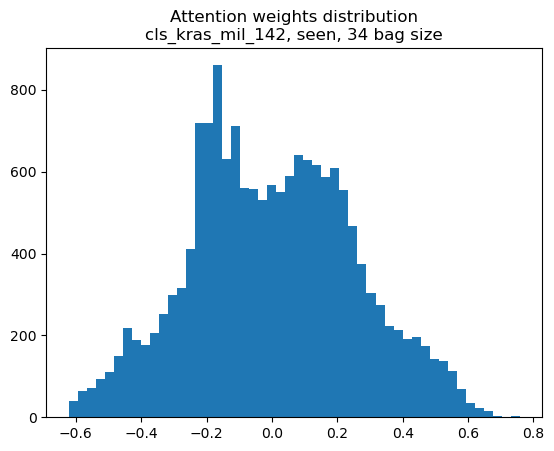

In [29]:
q0,q1 = attn.quantile([1/BAG_SIZE,(BAG_SIZE-1)/BAG_SIZE])

plt.hist(attn, bins=50)
# plt.axvline(1/BAG_SIZE, color='k', linestyle='--')
# plt.axvline(q1, color='r', linestyle='--') 
# plt.axvline(q0, color='r', linestyle='--') 
plt.title(f'Attention weights distribution\n{run_name}, {subset}, {BAG_SIZE} bag size');
plt.savefig(f'plots/attn/{run_name}/{subset}_attention_hist.pdf')

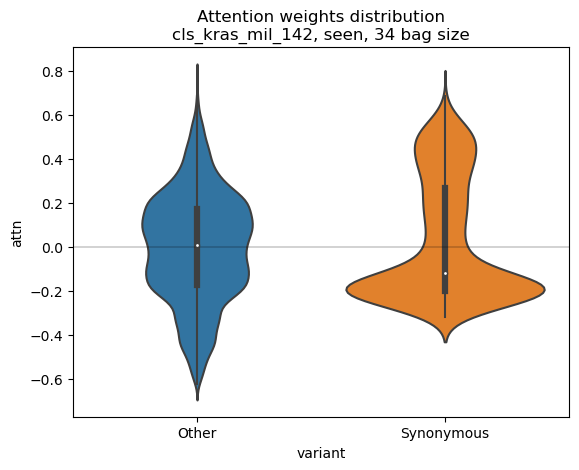

In [30]:
hue = df['variant'].map(lambda x : 'Synonymous' if x[0] == x[-1] or x=='WT' else 'Other')
sns.violinplot(df, y=attn, x=hue, )
plt.axhline(0,color= 'k', linewidth=1/4)
plt.title(f'Attention weights distribution\n{run_name}, {subset}, {BAG_SIZE} bag size');
plt.savefig(f'plots/attn/{run_name}/{subset}_attention_violin.pdf')

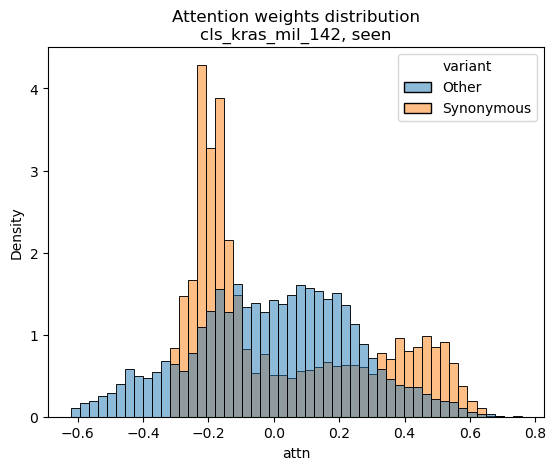

In [31]:
sns.histplot(df, x=attn, hue=hue, kde=False, bins=50, stat='density', common_norm=False)
plt.title(f'Attention weights distribution\n{run_name}, {subset}');

plt.savefig(f'plots/attn/{run_name}/{subset}_attention_hist_syn.pdf')

<Axes: xlabel='attn', ylabel='Density'>

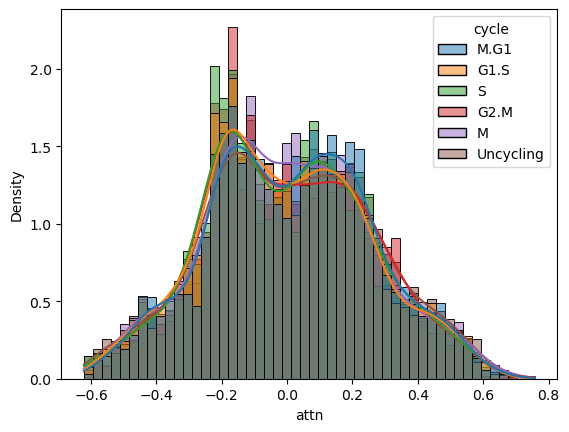

In [32]:
sns.histplot(df, x=attn, hue='cycle', kde=True, bins=50,
              hue_order=hue_order_cycle, common_norm=False,
              stat='density')

## Attention score by cell cycle

Text(0.5, 1.0, 'Attention logits depending on cell cycle\nError bars : 95% CI\ncls_kras_mil_142, seen')

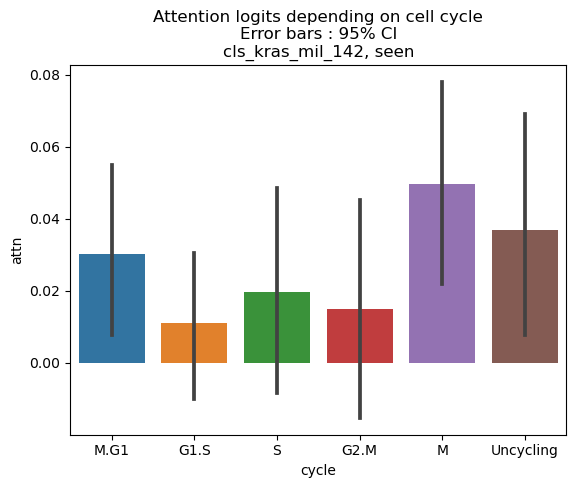

In [33]:
_df = df[hue == 'Synonymous']
sns.barplot(x='cycle', y=attn[_df.index], data=_df, errorbar=('ci',95), order=hue_order_cycle)
plt.title(f'Attention logits depending on cell cycle\nError bars : 95% CI\n{run_name}, {subset}')
# plt.savefig(f'plots/attn/{run_name}/{subset}_attention_cycle.pdf')

In [34]:
df.cycle.unique()

['G1.S', 'Uncycling', 'S', 'M', 'G2.M', 'M.G1']
Categories (6, object): ['G1.S', 'G2.M', 'M', 'M.G1', 'S', 'Uncycling']

(TP53) This is nice! We see that the classifier model prefers to look at G1 cells on all three splits 
This does not hold for the batch model, weirdly

(KRAS) : works quite well as well

Small sanity check to see if that discrepancy is not due to diff classes across variants

<Axes: xlabel='Variant functional class'>

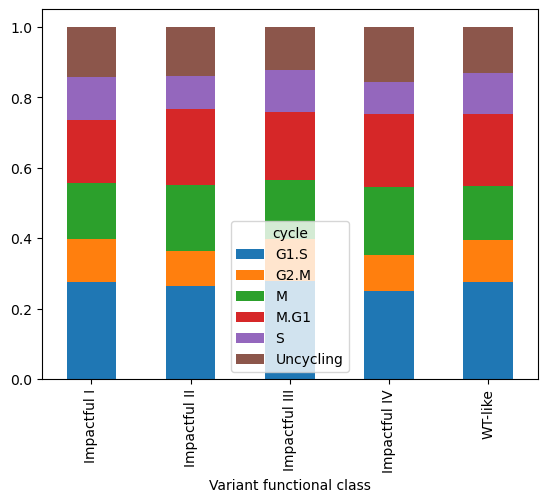

In [35]:
freqs = df.groupby('Variant functional class')['cycle'].value_counts(normalize=True).unstack()
freqs = freqs[freqs['M']>0] # remove missing variants 
freqs.plot(kind='bar', stacked=True)

## cell state and attention

In [36]:
pca = PCA(2).fit(emb_dict['seen'])

In [37]:
emb_red = pca.transform(embeds)


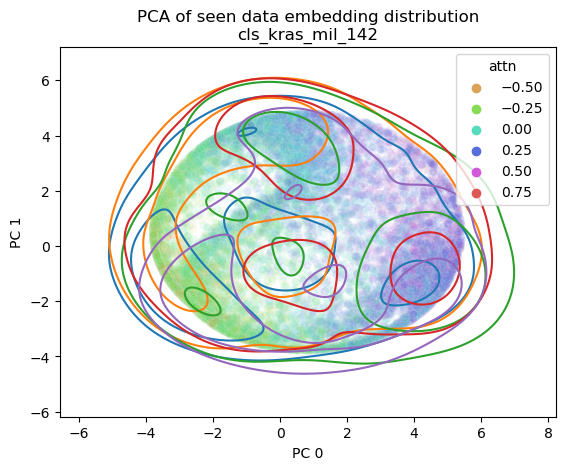

In [38]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = attn, palette='hls', alpha=0.1, 
             legend=True)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], 
            hue_order=hue_order, levels=3, common_norm=False, legend=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/attn/{run_name}/{subset}_embed_pca_kde.pdf')

## High attention cells

In [62]:
attn = attn_dict['seen']

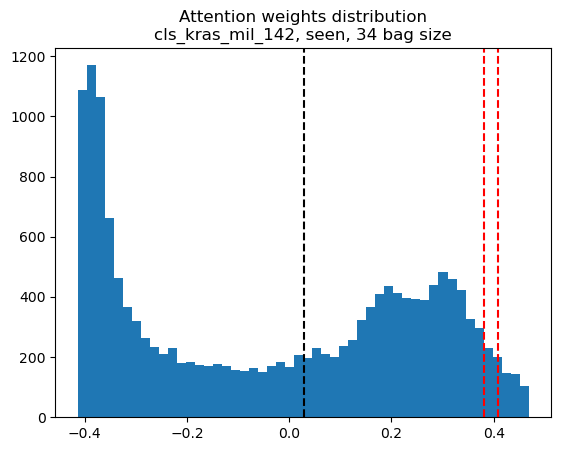

In [71]:
q0,q1 = attn.quantile([0.95,(BAG_SIZE-1)/BAG_SIZE])

plt.hist(attn, bins=50)
plt.axvline(1/BAG_SIZE, color='k', linestyle='--')
plt.axvline(q1, color='r', linestyle='--') 
plt.axvline(q0, color='r', linestyle='--') 
plt.title(f'Attention weights distribution\n{run_name}, {subset}, {BAG_SIZE} bag size');

In [80]:
df = df_seen.iloc[:, :-3] - df_seen.iloc[:, :-3].mean(0)

In [76]:
df.mean(0).sort_values(ascending=False).to_csv(f'tables/{run_name}_seen_mean.csv')

In [77]:
df.mean(0).sort_values(ascending=False).head(10)

TOB1               4.214786e-17
RP11-1094M14.11    4.214786e-17
SRGAP1             4.214786e-17
FHL2               4.126978e-17
PGK1               4.083074e-17
SNCG               3.995266e-17
EIF1AY             3.995266e-17
CA12               3.995266e-17
OSGIN1             3.995266e-17
ADAM17             3.863554e-17
dtype: float64

In [79]:
gene_coef = df_seen.iloc[:,:-3].mul(attn_dict['seen'], axis=0).mean(axis=0).sort_values()
gene_coef.to_csv(f'tables/{run_name}_attn_gene_coef_wavg.csv')

In [70]:
th = (BAG_SIZE-1)/BAG_SIZE*100
th

97.05882352941177

In [81]:
gene_coef = df.loc[attn > 0]
print(gene_coef.shape)
gene_coef = gene_coef.mean(axis=0).sort_values(ascending=False)
gene_coef.to_csv(f'tables/{run_name}_attn_gene_coef_pos.csv')
gene_coef

(8007, 1145)


RHOB       0.095407
S100A4     0.076665
IGFBP6     0.076171
LGALS1     0.071464
CCDC85B    0.071339
             ...   
AKR1C3    -0.072202
AKR1C2    -0.079685
SAMD11    -0.082146
TRAM1     -0.093212
LBH       -0.099910
Length: 1145, dtype: float64